Idea 1

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense, Dropout, Reshape, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
import numpy as np

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf

In [4]:
#FEC Google Dataset
print(os.listdir(r'C:\Users\ASUS\Desktop\Facial Emotion Comparison Detection\Dataset'))

['test', 'train']


In [5]:
train_path = r'C:\Users\ASUS\Desktop\Facial Emotion Comparison Detection\Dataset\train'
val_path = r'C:\Users\ASUS\Desktop\Facial Emotion Comparison Detection\Dataset\test'

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import Sequential
from tensorflow import keras
from sklearn.model_selection import KFold

In [7]:
emotion_labels = sorted(os.listdir(train_path))
print(emotion_labels)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [8]:
img_size = 48
batch_size = 32
num_classes = len(emotion_labels)

In [9]:
# Load datasets
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = image_dataset_from_directory(
    val_path,
    image_size=(img_size, img_size),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [10]:
# Normalize images
train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y))
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y))

# CNN Model for Feature Extraction
def cnn_feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Flatten()(x)
    return Model(inputs, x, name="CNN_FeatureExtractor")

In [11]:
class CapsuleLayer(tf.keras.layers.Layer):
    def __init__(self, num_capsules, dim_capsules, **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsules = num_capsules
        self.dim_capsules = dim_capsules

    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1], self.num_capsules * self.dim_capsules),
            initializer='glorot_uniform',
            trainable=True
        )

    def call(self, inputs):
        outputs = tf.keras.backend.dot(inputs, self.kernel)
        outputs = tf.keras.backend.reshape(outputs, (-1, self.num_capsules, self.dim_capsules))
        return outputs


In [12]:
# Hybrid Model
input_shape = (img_size, img_size, 3)
cnn_model = cnn_feature_extractor(input_shape)

inputs = Input(shape=input_shape)
features = cnn_model(inputs)


In [13]:
# Capsule Network
capsule = CapsuleLayer(num_capsules=10, dim_capsules=16)(features)


In [14]:

# LSTM for Temporal Pattern Recognition
x = Reshape((10, 16))(capsule)  # Reshape output to match LSTM input
x = LSTM(64, return_sequences=False)(x)
x = Dropout(0.5)(x)

In [15]:
# Fully Connected Output
outputs = Dense(num_classes, activation='softmax')(x)

In [16]:
# Build and Compile Model
hybrid_model = Model(inputs, outputs, name="Hybrid_CNN_Capsule_LSTM")
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Summary
hybrid_model.summary()

Model: "Hybrid_CNN_Capsule_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_FeatureExtractor            │ (None, 4608)           │        94,144 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_layer (CapsuleLayer)    │ (None, 10, 16)         │       737,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        20,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 852,615 (3.25 MB)

 Trainable params: 852,167 (3.25 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
# Training the Model
epochs = 50
hybrid_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 70s 78ms/step - accuracy: 0.6641 - loss: 0.9271 - val_accuracy: 0.5376 - val_loss: 1.2623
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 67s 75ms/step - accuracy: 0.6814 - loss: 0.8758 - val_accuracy: 0.5447 - val_loss: 1.2616
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 70s 78ms/step - accuracy: 0.7039 - loss: 0.8191 - val_accuracy: 0.5111 - val_loss: 1.3859
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.7355 - loss: 0.7512 - val_accuracy: 0.4897 - val_loss: 1.5049
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 71s 79ms/step - accuracy: 0.7563 - loss: 0.6841 - val_accuracy: 0.5359 - val_loss: 1.5064
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 71s 79ms/step - accuracy: 0.7819 - loss: 0.6185 - val_accuracy: 0.5474 - val_loss: 1.4670
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 77s 86ms/step - accuracy: 0.8051 - loss: 0.5746 - val_accuracy: 0.4936 - val_loss: 1.8510
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 72s 80ms/step - accuracy: 0.8156 - loss: 0.5337 - 

In [19]:
# Evaluate the Model
val_loss, val_accuracy = hybrid_model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5595 - loss: 3.0197
Validation Accuracy: 56.55%


In [28]:
import os
import numpy as np
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Add, Multiply, Concatenate, Lambda, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K


# Paths
train_path = r'C:\Users\ASUS\Desktop\Facial Emotion Comparison Detection\Dataset\train'
val_path = r'C:\Users\ASUS\Desktop\Facial Emotion Comparison Detection\Dataset\test'

# Get emotion labels
emotion_labels = sorted(os.listdir(train_path))
print("Emotion Labels: ", emotion_labels)

# Image and batch settings
batch_size = 64
target_size = (48, 48)

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=target_size,
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode='categorical'
)

Emotion Labels:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [29]:
# CBAM Block Definition
def cbam_block(input, ratio=8):
    # Channel Attention Module
    avg_pool = GlobalAveragePooling2D()(input)
    max_pool = GlobalMaxPooling2D()(input)
    
    avg_pool = Reshape((1, 1, input.shape[-1]))(avg_pool)
    max_pool = Reshape((1, 1, input.shape[-1]))(max_pool)
    
    # MLP for channel attention
    avg_pool = Dense(input.shape[-1] // ratio, activation='relu')(avg_pool)
    max_pool = Dense(input.shape[-1] // ratio, activation='relu')(max_pool)
    
    avg_pool = Dense(input.shape[-1], activation='sigmoid')(avg_pool)
    max_pool = Dense(input.shape[-1], activation='sigmoid')(max_pool)
    
    # Channel attention mechanism
    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Multiply()([input, channel_attention])
    
    # Spatial Attention Module
    avg_pool = Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(channel_attention)
    max_pool = Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(channel_attention)
    concat = Concatenate(axis=-1)([avg_pool, max_pool])
    
    spatial_attention = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(concat)
    
    # Apply spatial attention to the input
    return Multiply()([channel_attention, spatial_attention])

# Model Architecture with CBAM Blocks
input_shape = (48, 48, 1)  # Image dimensions: 48x48 pixels with 1 color channel (grayscale)
num_classes = len(emotion_labels)  # Number of emotion classes

# Create model input
inputs = Input(shape=input_shape)

# First Conv Block
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = cbam_block(x)  # Apply CBAM block

# Second Conv Block
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = cbam_block(x)  # Apply CBAM block

# Third Conv Block
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = cbam_block(x)  # Apply CBAM block

# Fourth Conv Block
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = cbam_block(x)  # Apply CBAM block

# Flatten and Dense Layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# Create final model
model = Model(inputs=inputs, outputs=outputs)

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 46, 46,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 23, 23,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_10… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 32)        │          0 │ max_pooling2d_10… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 4)   │        132 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1, 1, 4)   │        132 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1, 1, 32)  │        160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1, 1, 32)  │        160 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 32)  │          0 │ dense_3[0][0],    │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 23, 23,    │          0 │ max_pooling2d_10… │
│                     │ 32)               │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 23, 23, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 23, 23, 1) │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 23, 23, 2) │          0 │ lambda[0][0],     │
│ (Concatenate)       │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 23, 23, 1) │         99 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 23, 23,    │          0 │ multiply[0][0],   │
│ (Multiply)          │ 32)               │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 21, 21,    │     18,496 │ multiply_1[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 10, 10,    │          0 │ conv2d_12[0][0] 

 Total params: 568,011 (2.17 MB)

 Trainable params: 568,011 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 54s 107ms/step - accuracy: 0.2419 - loss: 1.8328 - val_accuracy: 0.2471 - val_loss: 1.8140
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 36s 81ms/step - accuracy: 0.2513 - loss: 1.8086 - val_accuracy: 0.2527 - val_loss: 1.7915
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.2579 - loss: 1.7833 - val_accuracy: 0.2953 - val_loss: 1.7267
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.3307 - loss: 1.6764 - val_accuracy: 0.4196 - val_loss: 1.5004
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.4296 - loss: 1.4683 - val_accuracy: 0.4473 - val_loss: 1.4218
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - accuracy: 0.4854 - loss: 1.3426 - val_accuracy: 0.4957 - val_loss: 1.3033
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.5069 - loss: 1.2778 - val_accuracy: 0.5063 - val_loss: 1.2719
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 83ms/step - accuracy: 0.5425 - loss: 1.2018 - val_accura

In [34]:
print("Validation Accuracy:", history.history['accuracy'][-1])  


Validation Accuracy: 0.7433557510375977


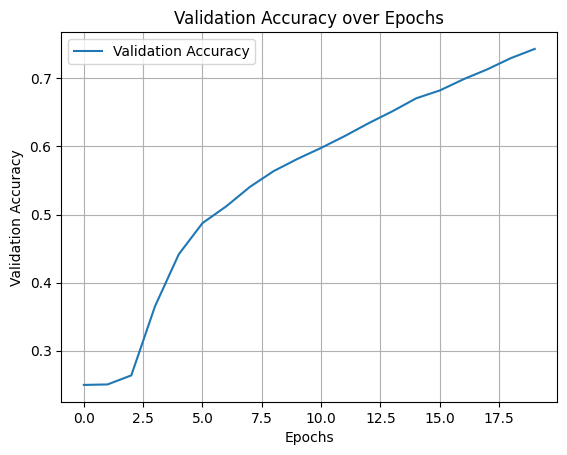

In [41]:
# Plotting the validation accuracy curve
plt.plot(history.history['accuracy'], label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()